# SWOT data acquisition

In [ ]:
# %%bash
# pip install descartes

In [1]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

### First, intersect the aufeis polygons with SWOT tiles

In [2]:
# ---------- Filepaths ----------
aufeis_AOI_filepath = "../Workspace/polygon_aufeis.shp"
SWOT_tiles_filepath = "../Workspace/nom_tile_bounds_v1.shp"

target_crs = "EPSG:32606"   # UTM zone 6N

In [3]:
# ---------- Subset SWOT tiles to North Slope AK ----------
# load SWOT tiles
SWOT_tiles = gpd.read_file(SWOT_tiles_filepath)
# print(SWOT_tiles.crs) #'epsg:4326'

# define bounding box
# currently this is set to eastern north slope ish ish (where colville turns north)
bbox = (-151.524048, 67.205182, -140.139127, 70.222115)  # (lon_min, lat_min, lon_max, lat_max)
# create bbox geometry
bbox_geom = box(*bbox)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs="EPSG:4326")

# subset!
SWOT_tiles_AK = SWOT_tiles[SWOT_tiles.intersects(bbox_gdf.geometry.iloc[0])]
# transform to local UTMs
SWOT_tiles_AK = SWOT_tiles_AK.to_crs(target_crs)

In [6]:
# ---------- Load aufeis polygons ----------
aufeis = gpd.read_file(aufeis_AOI_filepath).to_crs(target_crs)

aufeis CRS: EPSG:32606
SWOT tiles CRS: EPSG:32606


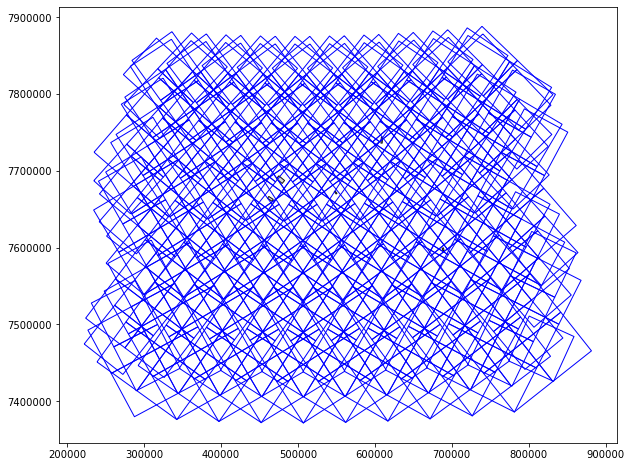

In [9]:
# ---------- Sanity checks before intersect ----------
# CRS checks
print("aufeis CRS:", aufeis.crs)
print("SWOT tiles CRS:", SWOT_tiles_AK.crs)

# Plot of SWOT & aufeis
fig, ax = plt.subplots(figsize=(10, 10))
aufeis.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.9)
SWOT_tiles_AK.plot(ax=ax, color='none', edgecolor='blue', linewidth=1)
plt.show()

In [10]:
# ---------- Intersect SWOT/aufeis polygons & list SWOT tiles to download ----------

# unary_union for an efficient intersection
aufeis_union = aufeis.unary_union

# boolean mask of tiles that intersect any aufeis polygon
mask = SWOT_tiles_AK.intersects(aufeis_union)

# subset the tiles that overlap
SWOT_tiles_overlap = SWOT_tiles_AK[mask].copy()

# print the pass and tile info
col = 'pass_tile'
if col in SWOT_tiles_overlap.columns:
    pass_values = sorted(SWOT_tiles_overlap[col].unique().tolist())
    print(f"{len(pass_values)} unique pass/tiles overlapping aufeis:")
    for v in pass_values:
        print(v)

32 unique pass/tiles overlapping aufeis:
024_029L
024_029R
024_030L
052_030L
181_278L
209_279R
237_279L
237_281L
246_028R
265_279L
265_280L
265_280R
265_282R
274_028L
274_029L
274_031R
293_281R
302_029R
302_030L
330_030L
487_278R
515_279L
515_280L
543_279L
543_280R
543_281R
552_028R
552_031R
571_280R
580_029L
580_029R
580_031L


In [ ]:
# ------------ use earthdata API to get SWOT data ------------
# get the download.sh file from earthdata on the Docker in the correct directory (SWOT_PIXC_data)
# in the terminal run:

# jovyan@c35f098b3a59:~/work$ pwd
# /home/jovyan/work
# jovyan@c35f098b3a59:~/work$ mv download.sh ../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/
# jovyan@c35f098b3a59:~/work$ cd ../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/
# jovyan@c35f098b3a59:/shared_space/SWOT_Aufeis/SWOT_PIXC_data$ ls
# download.sh

# cd ../../../shared_space/SWOT_Aufeis/SWOT_PIXC_data/
# chmod 777 download.sh
# ./download.sh